# 03 Dynamic Conditional Edge

## Setup

In [1]:
import uuid
import os
import nest_asyncio
from typing import Literal, TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command # Command 객체로 State 업데이트와 라우팅 동시에 하기
from dotenv import load_dotenv

load_dotenv()

True

## Define state schemas

In [2]:
class EmailState(TypedDict):
    email_content: str
    priority: str
    spam_score: float
    action_taken: str

## Define Nodes, Edges
- Command를 사용함으로써,
    - State 업데이트: `update` 파라미터
    - 다음 Node 지정: `goto` 파라미터

In [3]:
def classify_email(state: EmailState) -> Command[Literal["urgent", "normal", "spam"]]:
    """
    이메일을 분석하여 우선순위를 결정하고 라우팅
    Command로 State 업데이트 + 라우팅을 동시에 처리
    """
    content = state["email_content"].lower()

    # 간단한 스팸 점수 계산
    spam_keywords = ["광고", "할인", "무료", "클릭"]
    spam_score = sum(1 for kw in spam_keywords if kw in content) / len(spam_keywords)

    # 우선순위 결정 및 라우팅
    if spam_score > 0.5:
        return Command(
            update={"priority": "spam", "spam_score": spam_score}, goto="spam"
        )
    elif "긴급" in content or "urgent" in content:
        return Command(
            update={"priority": "urgent", "spam_score": spam_score}, goto="urgent"
        )
    else:
        return Command(
            update={"priority": "normal", "spam_score": spam_score}, goto="normal"
        )


def handle_urgent(state: EmailState) -> dict:
    return {"action_taken": "즉시 알림"}


def handle_normal(state: EmailState) -> dict:
    return {"action_taken": "받은편지함"}


def handle_spam(state: EmailState) -> dict:
    return {"action_taken": "스팸 폴더"}


# Build the graph

In [4]:
# 그래프 생성
email_graph = StateGraph(EmailState)
email_graph.add_node("classify", classify_email)
email_graph.add_node("urgent", handle_urgent)
email_graph.add_node("normal", handle_normal)
email_graph.add_node("spam", handle_spam)

# Edge 추가
email_graph.add_edge(START, "classify")
# Command를 사용하므로 조건부 엣지가 자동으로 처리됨
email_graph.add_edge("urgent", END)
email_graph.add_edge("normal", END)
email_graph.add_edge("spam", END)

# 컴파일 및 테스트
email_app = email_graph.compile()

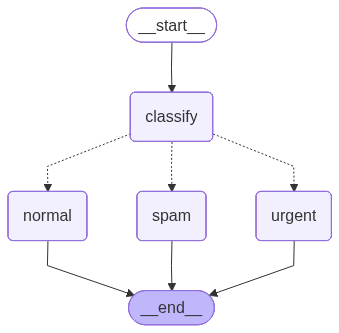

In [6]:
# 그래프 그리기
from IPython.display import Image, display
display(Image(email_app.get_graph().draw_mermaid_png()))

## Test

In [ ]:
emails = [
    {"email_content": "긴급! 서버 다운 발생"},
    {"email_content": "회의 일정 안내드립니다"},
    {"email_content": "광고! 무료 할인 이벤트 클릭하세요"},
]

for email in emails:
    print(f"\n{'=' * 60}")
    print(f"이메일: {email['email_content']}")
    result = email_app.invoke(email)
    print(f"결과: 우선순위={result['priority']}, 조치={result['action_taken']}")


이메일: 긴급! 서버 다운 발생
결과: 우선순위=urgent, 조치=즉시 알림

이메일: 회의 일정 안내드립니다
결과: 우선순위=normal, 조치=받은편지함

이메일: 광고! 무료 할인 이벤트 클릭하세요
결과: 우선순위=spam, 조치=스팸 폴더


: 